# Ajuste de curvas

In [7]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed, widgets

Populating the interactive namespace from numpy and matplotlib


El problema clásico de ajuste de curvas es dado un conjunto de puntos, encontrar la curva que **mejor** representa los datos. Donde **mejor** está sujeto a definición.

Para hacerlo más divertido, verémos el problema de ajuste de curvas como un problema de optimización y en particular como un método de aprendizaje de máquina (_machine learning_) supervisado.

Supongamos que tenemos un conjunto $m$ de datos de entrada $\textbf{x}$ (en aprendizaje de máquina se les conoce como _features_) y sus datos dependientes, $\textbf{y}$ (_target_ en aprendizaje de máquina). A este conjunto $(x^{(i)}, y^{(i)})$, le llamamos conjunto de entrenamiento. Queremos desarrollar un modelo $\hat{\textbf{y}}$ que aproxime el valor de $\textbf{y}$.

(Estamos asumiendo que y depende de x)

La primera aproximación es intentar una aproximación de forma lineal, conocida como _regresión lineal_, de la forma

$$
\hat{\textbf{y}} = \mathbf\beta_0 + \mathbf\beta_1 \textbf{x}
$$

Donde (si recuerdan Geometría Analítica) $\beta_0$ es el _interceptor_ de la recta $\hat{\textbf{y}}$ y $\beta_1$ es la _pendiente_ de la recta. A $\hat{\textbf{y}}$ se le conoce también como _hipótesis_ y se le puede denotar con la variable $\textbf{h}$. Si definimos que $x_0 \equiv 1$, podemos escribir la _hipótesis_ de manera más compacta:

$$
\hat{\textbf{y}} = \sum_{j=0}^n \beta_j x_j = \mathbf{\beta}^T\textbf{x}
$$

(Y es un plano en función de x.)


Con esta notación, podemos extender el formalismo a más dimensiones (en este caso $n$). 

Vamos a tomar vectores verticales

Una posible definición de **mejor** es que el modelo (el cual está determinado por $\vec\beta$) minimice la suma de las diferencias entre el valor actual $\textbf{y}$ y el predicho $\hat{\textbf{y}}$ (a esta diferencia se le conoce como _error en la predicción_), en otras palabras _minimizar la suma del cuadrado de los residuos_. La función a minimizar se conoce en aprendizaje de máquina como _función de costo_ $\textbf{J}$. Debido a que tenemos varios pares $(x_i, y_i)$, la función costo a minimizar es el _error cuadrático promedio_.

(Vamos a minimizar la suma de los errores al cuadrado)

$$\textbf{J}(\beta_0, \beta_1) = \frac{1}{2n}\sum_{(x^{(i)}, y^{(i)}) \in X \times Y} (y^{(i)} - \hat{y}^{(i)}(x^{(i)}))^2 = \frac{1}{2n}\sum_{(x^{(i)}, y^{(i)}) \in X \times Y} (y^{(i)} - \beta_0 - \beta_1 x^{(i)})^2$$

El factor de $2$ se agrega para simplificar cálculos posteriores. Visto así, el objetivo de un algoritmo supervisado de aprendizaje de máquina es encontrar $\beta_0$ y $\beta_1$ que minimiza la función de costo $\textbf{J}(\beta_0, \beta_1)$. Esto se puede hacer mediante un algoritmo llamado _gradient descent_.

## Gradient descent

El gradiente de una función (hacia donde decrece la función, moverse en el sentido opuesto al gradiente) $g(x,y)$ es:

$$
\nabla g (x, y) = \left [ \partial_x g, \ \partial_y g\right]
$$
(Ese vector deberia ser vertical)


donde $\partial_x$, $\partial_y$ es la derivada parcial respecto a $x$ y $y$ respectivamente. el significado geométrico del gradiente de una función, es el vector que apunta en la dirección donde se maximiza el incremento de la función. Por lo tanto, si queremos minimizar la función, recorremos el vector en el sentido contrario.

### Algoritmo

1. Escoger un punto al azar, llama a este punto $\boldsymbol{B}_0$.
2. Calcular el gradiente de $\textbf{J}$ en esa locación.
3. Actualiza la locación en el sentido opuesto a donde apunte el gradiente, específicamente resta a $\boldsymbol{B}_0$ el valor de $\alpha\nabla\textbf{J}$, donde $\alpha$ es un número pequeño, conocido como _learning rate_.
4. Repite los pasos $2$ y $3$ cuantas veces sea necesario.

Estamos buscando las betas

En pseudocódigo:

<div class="alert alert-warning">
_repetir hasta que lograr convergencia {_

$$\beta_(j+1) := \beta_j - \alpha \frac{\partial}{\partial \beta_j} \textbf{J}(\beta)$$

_}_
</div>

Se deja como ejercicio de tarea, demostrar que 

$$
\frac{\partial}{\partial \beta_j} \textbf{J}(\beta) = \frac{1}{m}\sum_{i=1}^{m}\left(\hat{y}(x^{(i)}) - y(x^{(i)})\right) \cdot x^{(i)}_j
$$

Entonces:

<div class="alert alert-warning">
_repetir hasta que lograr convergencia {_

$$
\beta_j := \beta_j - \alpha\frac{1}{m}\sum_{i=1}^{m}\left(\hat{y}(x^{(i)}) - y(x^{(i)})\right) \cdot x^{(i)}_j
$$

_}_
</div>

In [27]:


class RegresionLineal:
    def __init__(self, alpha=0.3, max_iters=100, tols=0.001):
        """
        Parámetros.
        ---------------
        alpha = Learning rate
        max_iters = Número máximo de iteraciones
        tols = definición de convergencia, que tanto nos estamos acercando
        """
        self.alpha = alpha
        self.max_iters = max_iters
        self.tols = tols
        self.breaking_iteration = None
        self.historia = {'costo':[], 'beta':[]}  # Con fines de graficación
        
    def gradientDescent(self, x, y):
        """
        Parámetros:
        ---------------
        x = vector de entrenamiento de features
        y = vector de entrenamiento de variable a predecir (target)
        """    
        
        # ajustamos el vector de features
        unos = np.ones((x.shape[0], 1))
        Xt = x.reshape(x.shape[0], 1)
        Xt = np.concatenate((unos, Xt), axis=1)
        
        i = 0
        prep_J = 0
        m, n = Xt.shape
        self.beta = np.zeros(n) 
        
        while i < self.max_iters:     
            # Actualizamos beta (con la formula de betaj)
            self.beta = self.beta - self.alpha * self.gradiente(Xt, y)
            
            J = self.costo(Xt, y)
            
            #En el if estamos checando la convergencia
            if abs(J - prep_J) <= self.tols:
                print('La función convergió con beta: %s en la iteración %i' % ( str(self.beta), i ))
                self.breaking_iteration = i
                break
            else:
                prep_J = J
            
            self.historia['costo'].append(J)
            self.historia['beta'].append(self.beta)                
            i += 1
    
    def hipotesis(self, x):
        #Producto punto
        return np.dot(x, self.beta)
    
    def costo(self, x, y):
        #La diferencia
        m = x.shape[0]
        error = self.hipotesis(x) - y
        return np.dot(error.T, error) / (2 * m) 
    
    def gradiente(self, x, y):
        m = x.shape[0]
        error = self.hipotesis(x) - y        
        return np.dot(x.T, error) / m    

In [26]:
r = RegresionLineal(alpha=0.03, max_iters=10000, tols=0)
r.gradientDescent(X, Y)

La función convergió con beta: [0.75016248 0.06388118] en la iteración 5247


In [24]:
objeto = RegresionLineal()
print(objeto.alpha)
print(objeto.max_iters)
print(objeto.tols)

0.3
100
0.001


### Ejemplo

Los archivos `edad.dat` y `altura.dat` contienen las mediciones de las estaturas (en metros) de varios niños entre las edad de 2 y 8 años. Cada _tupla_ de altura y edad, constituyen un ejemplo de entrenamiento $(x^{(i)}, y^{(i)})$ de nuestros datos. Hay $m = 50$ datos para entrenar que usaremos para realizar un modelo de regresión lineal.

In [10]:
X = np.loadtxt('data/edad.dat')
Y = np.loadtxt('data/altura.dat')

Los datos se ven así:

Text(0, 0.5, 'Altura (m)')

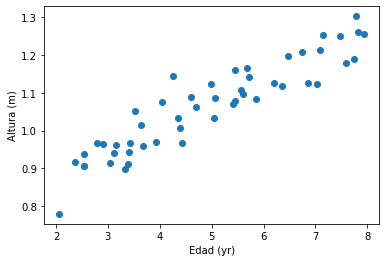

In [11]:
plt.scatter(X,Y, label="data")
plt.xlabel('Edad (yr)')
plt.ylabel('Altura (m)')

<div class="alert alert-info">

**Ejercicio:** Usando el _widget_ siguiente, trata de encontrar al "tanteo" cuál es la recta que mejor minimiza el error.

</div>

In [12]:
def plotGuess(x, y, interceptor, pendiente):
    
    modelo = lambda x,b,m: b + m*x # función para graficar el modelo
    
    plt.scatter(X,Y, label="data")
    plt.plot(X, modelo(X, interceptor, pendiente), label='Guess')
    plt.xlabel('Edad (yr)')
    plt.ylabel('Altura (m)')
    plt.legend(loc="best")

In [14]:
interact(plotGuess, x=fixed(X), y=fixed(Y), interceptor=(0,2,0.02), pendiente=(0,2, 0.02));

interactive(children=(FloatSlider(value=1.0, description='interceptor', max=2.0, step=0.02), FloatSlider(value…

Entrenamos la regresión lineal con un _learning rate_ de $\alpha = 0.03$

In [16]:
r = RegresionLineal(alpha=0.03, max_iters=10000, tols=0.0000001)
r.gradientDescent(X, Y)

La función convergió con beta: [0.73300235 0.06700325] en la iteración 1190


In [22]:
r.historia

{'costo': [0.04196285369420835,
  0.028497207456174154,
  0.02799508432407656,
  0.027818203793219122,
  0.027650483302613885,
  0.027484011404447548,
  0.02731858387292772,
  0.027154189275183954,
  0.026990821039476323,
  0.0268284727548829,
  0.026667138053502678,
  0.026506810607266108,
  0.02634748412761328,
  0.026189152365245508,
  0.0260318091098801,
  0.025875448190006818,
  0.02572006347264578,
  0.025565648863106902,
  0.02541219830475091,
  0.025259705778751685,
  0.02510816530386024,
  0.024957570936170105,
  0.024807916768884178,
  0.024659196932083075,
  0.024511405592494845,
  0.024364536953266232,
  0.024218585253735204,
  0.024073544769205094,
  0.02392940981072007,
  0.023786174724841885,
  0.023643833893428234,
  0.02350238173341235,
  0.023361812696584043,
  0.023222121269372044,
  0.023083301972627757,
  0.022945349361410402,
  0.022808258024773344,
  0.022672022585551968,
  0.022536637700152684,
  0.022402098058343378,
  0.02226839838304513,
  0.02213553343012518

<div class="alert alert-info">
**Ejercicio: ** Agrega un _widget_ de interacción en el cual puedas modificar $\alpha$. ¿Qué observas?
</div>

In [30]:
def plotModelo(x,y,rl,iteracion):
    modelo = lambda x,b,m: b + m*x # función para graficar el modelo
    
    _beta = rl.historia['beta'][iteracion]

    fig, ax = plt.subplots(1,2, figsize=(10,6))
    ax[0].scatter(x,y, label="datos")
    ax[0].plot(x, modelo(x, _beta[0], _beta[1]), label="int: %1.2f, pen: %1.2f" % (_beta[0], _beta[1]))
    ax[0].set_xlabel('Edad (yr)')
    ax[0].set_ylabel('Altura (m)')
    ax[0].legend(loc="best")
    #ax[0].set_xlim(0, max(x))
    #ax[0].set_ylim(0, max(y))
    
    costo  = rl.historia['costo']
    
    iteraciones = [i for i in range(0, len(costo))]
    ax[1].plot(iteraciones, costo, 'g', label="costo")
    ax[1].plot(iteracion, costo[iteracion], 'or', label="iteracion")
    ax[1].set_xlabel('Iteraciones')
    ax[1].set_ylabel('Costo')
    ax[1].legend(loc="best")

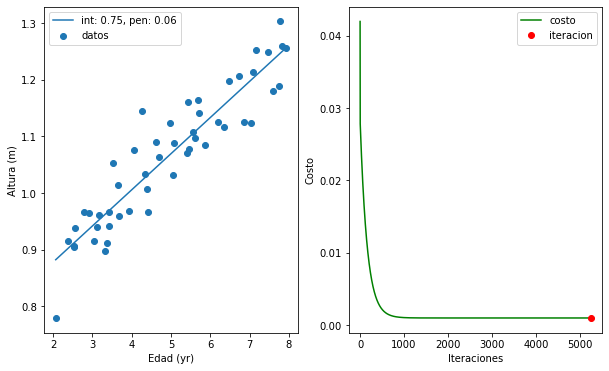

In [37]:
plotModelo(X,Y, r, 5246)
#El ultimo numero es la ultima iteracion

In [39]:
ultima_iteracion = (r.breaking_iteration - 1) if r.breaking_iteration else (r.max_iters - 1)

interact(plotModelo, x=fixed(X), y=fixed(Y), rl=fixed(r), iteracion=(0,ultima_iteracion,10)); #El 10 es el cambio en el interact

interactive(children=(IntSlider(value=2620, description='iteracion', max=5246, step=10), Output()), _dom_class…

<div class="alert alert-info">
**Ejercicio**: Modifica el _widget_ que creaste, para que dibujes la última iteración ¿Tienes una mejor intuición de $\alpha$?
</div>

## Una cosa más...

<div class="alert alert-warning">

A pesar de que la regresión lineal (obtenida con el _gradient descent_) parece un algoritmo muy simple, los conceptos son los mismos que para algoritmos de aprendizaje de máquina más avanzados, i.e. minimizar una función de costo. Estos algoritmos simplemente reemplazan el modelo linear con un modelo más complejo (y con una función de costo más compleja). De cierta manera, los algoritmos de aprendizaje de máquina son problemas de optimización.

</div>